<a href="https://colab.research.google.com/github/2SEHI/Factory-Anomaly-Analysis/blob/main/2_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81%EA%B3%BC%20%EC%A3%BC%EC%84%B1%EB%B6%84%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3가지의 정규화를 이용한 PCA주성분 분석결과 비교
- 데이터 스케일링은 MinMaxScaler, StandardScaler, LogScaler 3가지를 확인해봄

## 1.데이터 스케일링의 종류와 개념

### 1) MinMaxScaler
- 모든 feature를 0~1 사이의 값으로 조정
- 단점 : 이상치가 있다면, 매우 좁은 범위로 압출될 수 있음

### 2) StandardScaler를 이용한 PCA주성분 분석
- 평균과 표준편차를 이용 (x - mean)/(std_deviation)
- 단점 : 이상치가 있으면 변환된 데이터 확산이 매우 달라져 균형잡힌 척도 보장 X
- 넓게 분포된 데이터 보다는 모여진 데이터가 예측률이 좋다



### 3) RobustScaler를 이용한 PCA주성분 분석
- Standard Scaler 와 비슷하지만 평균대신 중앙값 사용 => 극단값(이상치, outlier)에 영향을 받지 않는다


## 2.공통 모듈 임포트

In [ ]:
# colab에서 실행시 matplotlib에 한글을 표시하기 위해서 본 셀을 실행후 runtime을 재시작해야 함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Display_Sensor_Anomaly_Analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
 
## colab용 글씨체 설정
plt.rc('font', family='NanumBarunGothic') 

## local jupyter 용 글씨체 설정
# font_path = "C:\Windows\Fonts\malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# mpl.rc('font', family=font)

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3.함수 생성

### 1) 데이터 스케일링결과를 반환하는 함수

In [ ]:
def scale(feature_data):
    from sklearn.preprocessing import MinMaxScaler
    minMaxScaler = MinMaxScaler()
    %time print(minMaxScaler.fit(feature_data))
    feature_data_minMaxScaled =  pd.DataFrame(minMaxScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    # from sklearn.preprocessing import MaxAbsScaler
    # maxAbsScaler = MaxAbsScaler()
    # %time print(maxAbsScaler.fit(feature_data))
    # feature_data_maxAbsScaled = pd.DataFrame(maxAbsScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    from sklearn.preprocessing import StandardScaler
    standardScaler = StandardScaler()
    %time print(standardScaler.fit(feature_data))
    feature_data_standardScaled = pd.DataFrame(standardScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    from sklearn.preprocessing import RobustScaler
    robustScaler = RobustScaler()
    %time print(robustScaler.fit(feature_data))
    feature_data_robustScaled = pd.DataFrame(robustScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)
    return feature_data_minMaxScaled, feature_data_standardScaled, feature_data_robustScaled

### 2) pca주성분 결과의 누적 기여율을 구하는 함수

In [ ]:
def get_pca(feature_data):
    from sklearn.decomposition import PCA
    pca = PCA()
    pca.fit(feature_data)
    feature_data_pca = pca.transform(feature_data)

    # 주성분의 설명력과 기여율 구하기
    result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
                '기여율':pca.explained_variance_ratio_},
                index=np.array([f"pca{num+1}" for num in range(feature_data_pca.shape[1])]))
    result['누적기여율'] = result['기여율'].cumsum()
    result

## 4.VIF까지 마친 데이터

### 1) 피처와 레이블데이터 불러오기
- 피처의 크기 : 8145 rows × 165 columns(dat...date.name.는 index임)
- 레이블의 크기 : 8145 rows × 4 columns

In [22]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/data/'
fact_lr_VIF_feature = pd.read_csv(working_dir + 'fact_lr_VIF_feature.csv', index_col=0)
fact_lr_labels = pd.read_csv(working_dir + 'fact_lr_labels.csv', index_col=0)

print(fact_lr_VIF_feature.shape)
print(fact_lr_labels.shape)

(8145, 165)
(8145, 4)


### 2) 데이터스케일링 하기전 피처의 통계정보확인

In [ ]:
fact_lr_VIF_feature.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,-0.000109,-0.000066,-0.000066,-0.000126,0.000195,0.000865,-0.000921,-0.001064,-0.000745,-0.001166,0.000506,-0.000164,-0.002465,0.000362,0.000672,0.000133,0.000599,-0.000518,-0.000462,-0.000374,0.000010,-0.000065,-0.000015,0.000020,-0.002179,0.000004,0.000248,0.000088,0.000015,-0.000738,-0.000007,-0.000013,-0.000010,0.000115,-0.000010,0.000586,-0.001312,0.000114,-0.000012,0.000059,...,0.000414,0.000162,0.000264,0.000042,0.000753,0.001017,0.001362,0.000378,0.001271,0.000974,0.001102,0.001712,-0.000583,0.000253,-0.000464,-0.000169,-0.000120,0.000321,-0.000605,-0.000147,-0.000585,0.000553,0.000667,0.000614,-0.000795,0.000196,0.000196,0.001021,-0.000788,-0.000435,0.000010,0.000490,-0.000193,-0.000032,0.000028,0.000325,-0.000536,-0.000530,-0.000437,0.000242
std,1.000423,1.000427,1.000427,1.000420,1.000407,0.999994,0.999936,0.999770,1.000106,0.999638,1.000281,1.000414,0.996887,1.000346,1.000141,1.000417,1.000221,1.000273,1.000305,1.000348,1.000430,1.000427,1.000430,1.000429,0.996634,1.000430,1.000394,1.000425,1.000430,1.000113,1.000430,1.000430,1.000430,1.000422,1.000430,1.000229,0.999675,1.000360,1.000368,1.000366,...,1.000329,1.000414,1.000388,1.000427,1.000099,0.999827,0.999342,1.000344,0.999486,0.999875,0.999720,0.998717,1.000231,1.000391,1.000302,1.000411,1.000420,1.000369,1.00021

### 3) 데이터 스케일링

In [64]:
X_mm_VIF_scaled, X_std_VIF_scaled, X_rbs_VIF_scaled =  scale(fact_lr_VIF_feature)

MinMaxScaler(copy=True, feature_range=(0, 1))
CPU times: user 9.08 ms, sys: 0 ns, total: 9.08 ms
Wall time: 11.4 ms
StandardScaler(copy=True, with_mean=True, with_std=True)
CPU times: user 20.4 ms, sys: 353 µs, total: 20.8 ms
Wall time: 20.8 ms
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
CPU times: user 60.5 ms, sys: 0 ns, total: 60.5 ms
Wall time: 61.9 ms


### 4) 데이터 스케일링 전의 주성분분석 결과

In [65]:
vif_result = get_pca(fact_lr_VIF_feature)
vif_result

NameError: ignored

### 5) 데이터 스케일링한 후의 주성분분석 결과

In [ ]:
mm_VIF_result = get_pca(X_mm_VIF_scaled)
mm_VIF_result

In [ ]:
std_VIF_result = get_pca(X_std_VIF_scaled)
std_VIF_result

In [ ]:
rbs_VIF_result = get_pca(X_rbs_VIF_scaled)
rbs_VIF_result

In [37]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

X_mm_VIF_data = pd.DataFrame(data=mm_scaler.fit_transform(fact_lr_VIF_feature), columns=fact_lr_VIF_feature.columns, index=fact_lr_VIF_feature.index)

### 2) 정규화 데이터의 분포 확인

In [38]:
X_mm_VIF_data.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,0.988214,0.994107,0.994107,0.982320,0.529466,0.525169,0.610950,0.380635,0.882136,0.658400,0.875308,0.964641,0.205599,0.910308,0.899328,0.359994,0.273476,0.369201,0.275230,0.325675,0.000123,0.502846,0.999724,0.500373,0.037147,0.003712,0.075292,0.008076,0.000222,0.589091,0.999492,0.999754,0.999877,0.013128,0.999877,0.308460,0.455802,0.294897,0.666264,0.201911,...,0.572061,0.139944,0.587133,0.640972,0.692536,0.466686,0.528494,0.734096,0.460561,0.598895,0.596825,0.622731,0.465213,0.667876,0.574495,0.678607,0.476233,0.430342,0.530023,0.519438,0.467738,0.328080,0.147908,0.413764,0.519405,0.464224,0.351680,0.348338,0.567445,0.487100,0.441858,0.373504,0.475686,0.610101,0.545925,0.680393,0.418794,0.344783,0.456452,0.332634
std,0.093284,0.076545,0.076545,0.120092,0.129666,0.355949,0.278701,0.158362,0.135831,0.169708,0.180221,0.184697,0.275895,0.026891,0.032969,0.027423,0.129259,0.096405,0.164278,0.171685,0.011080,0.011209,0.015717,0.015667,0.178202,0.015635,0.260872,0.079100,0.012401,0.478250,0.011077,0.015669,0.011080,0.098121,0.011080,0.451787,0.108320,0.076464,0.025378,0.031673,...,0.107547,0.030724,0.100994,0.101941,0.119709,0.119996,0.097228,0.104138,0.096378,0.109414,0.112630,0.149610,0.141090,0.096304,0.117128,0.120139,0.122956,0.165462,0.126784,0.142875,0.144254,0.143745,0.047157,

### 3) PCA주성분분석

In [49]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_mm_VIF_data)
X_mm_VIF_pca = pca.transform(X_mm_VIF_data)

# 주성분의 설명력과 기여율 구하기
mm_result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(X_mm_VIF_pca.shape[1])]))
mm_result['누적기여율'] = mm_result['기여율'].cumsum()
mm_result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,0.824083,0.259334,0.259334
pca2,0.422667,0.133011,0.392345
pca3,0.313368,0.098615,0.490960
pca4,0.170837,0.053761,0.544721
pca5,0.119679,0.037662,0.582383
...,...,...,...
pca161,0.000039,0.000012,0.999976
pca162,0.000025,0.000008,0.999983
pca163,0.000024,0.000007,0.999991
pca164,0.000016,0.000005,0.999996


#### 누적기여율이 90%가 되는 피처의 개수확인

In [50]:
print(len(mm_result[mm_result['누적기여율'] <= 0.9]))

29


In [51]:
mm_result[mm_result['누적기여율'] <= 0.9]

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,0.824083,0.259334,0.259334
pca2,0.422667,0.133011,0.392345
pca3,0.313368,0.098615,0.490960
pca4,0.170837,0.053761,0.544721
pca5,0.119679,0.037662,0.582383
pca6,0.114725,0.036103,0.618487
pca7,0.089611,0.028200,0.646687
pca8,0.083594,0.026307,0.672993
pca9,0.072931,0.022951,0.695944
pca10,0.068718,0.021625,0.717570


## 4.StandardScaler를 이용한 PCA주성분 분석
- 평균과 표준편차를 이용 (x - mean)/(std_deviation)
- 단점 : 이상치가 있으면 변환된 데이터 확산이 매우 달라져 균형잡힌 척도 보장 X
- 넓게 분포된 데이터 보다는 모여진 데이터가 예측률이 좋다



### 1) StandardScaler

In [42]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

X_std_VIF_data = pd.DataFrame(data=std_scaler.fit_transform(fact_lr_VIF_feature), columns=fact_lr_VIF_feature.columns, index=fact_lr_VIF_feature.index)

### 2) 정규화 데이터의 분포 확인

In [ ]:
X_std_VIF_data.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,0.988214,0.994107,0.994107,0.982320,0.529466,0.525169,0.610950,0.380635,0.882136,0.658400,0.875308,0.964641,0.205599,0.910308,0.899328,0.359994,0.273476,0.369201,0.275230,0.325675,0.000123,0.502846,0.999724,0.500373,0.037147,0.003712,0.075292,0.008076,0.000222,0.589091,0.999492,0.999754,0.999877,0.013128,0.999877,0.308460,0.455802,0.294897,0.666264,0.201911,...,0.572061,0.139944,0.587133,0.640972,0.692536,0.466686,0.528494,0.734096,0.460561,0.598895,0.596825,0.622731,0.465213,0.667876,0.574495,0.678607,0.476233,0.430342,0.530023,0.519438,0.467738,0.328080,0.147908,0.413764,0.519405,0.464224,0.351680,0.348338,0.567445,0.487100,0.441858,0.373504,0.475686,0.610101,0.545925,0.680393,0.418794,0.344783,0.456452,0.332634
std,0.093284,0.076545,0.076545,0.120092,0.129666,0.355949,0.278701,0.158362,0.135831,0.169708,0.180221,0.184697,0.275895,0.026891,0.032969,0.027423,0.129259,0.096405,0.164278,0.171685,0.011080,0.011209,0.015717,0.015667,0.178202,0.015635,0.260872,0.079100,0.012401,0.478250,0.011077,0.015669,0.011080,0.098121,0.011080,0.451787,0.108320,0.076464,0.025378,0.031673,...,0.107547,0.030724,0.100994,0.101941,0.119709,0.119996,0.097228,0.104138,0.096378,0.109414,0.112630,0.149610,0.141090,0.096304,0.117128,0.120139,0.122956,0.165462,0.126784,0.142875,0.144254,0.143745,0.047157,

### 3) PCA주성분분석

In [46]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_std_VIF_data)
X_std_VIF_pca = pca.transform(X_std_VIF_data)

# 주성분의 설명력과 기여율 구하기
std_result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(X_std_VIF_pca.shape[1])]))
std_result['누적기여율'] = std_result['기여율'].cumsum()
std_result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,25.035410,0.151711,0.151711
pca2,14.242599,0.086308,0.238019
pca3,9.632294,0.058370,0.296390
pca4,7.716688,0.046762,0.343152
pca5,6.119540,0.037084,0.380235
...,...,...,...
pca161,0.016939,0.000103,0.999674
pca162,0.015368,0.000093,0.999767
pca163,0.015145,0.000092,0.999859
pca164,0.012513,0.000076,0.999935


#### 누적기여율이 90%가 되는 피처의 개수확인

In [47]:
print(len(std_result[std_result['누적기여율'] <= 0.9]))

57


In [48]:
std_result[std_result['누적기여율'] <= 0.9]

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,25.035410,0.151711,0.151711
pca2,14.242599,0.086308,0.238019
pca3,9.632294,0.058370,0.296390
pca4,7.716688,0.046762,0.343152
pca5,6.119540,0.037084,0.380235
pca6,5.281807,0.032007,0.412242
pca7,4.865974,0.029487,0.441729
pca8,4.328912,0.026233,0.467962
pca9,3.625058,0.021967,0.489929
pca10,3.475860,0.021063,0.510993


## 5.RobustScaler를 이용한 PCA주성분 분석
- Standard Scaler 와 비슷하지만 평균대신 중앙값 사용 => 극단값(이상치, outlier)에 영향을 받지 않는다


### 1) RobustScaler

In [53]:
from sklearn.preprocessing import RobustScaler
rbs_scaler = RobustScaler()

X_rbs_VIF_data = pd.DataFrame(data=rbs_scaler.fit_transform(fact_lr_VIF_feature), columns=fact_lr_VIF_feature.columns, index=fact_lr_VIF_feature.index)

### 2) 정규화 데이터의 분포 확인

In [54]:
X_rbs_VIF_data.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,UPPER.AB6.Z71.TMP.1TIC41601.PV,UPPER.C1..Z157.TMP.1TIC42203.PV,UPPER.C2..Z169.TMP.1TIC42301.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,...,D_AB3_U_LR,D_AB3_L_LR,D_AB4_L_LR,D_AB5_U_LR,D_AB6_U_LR,D_AB7_U_LR,D_AB8_U_LR,D_AB8_L_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_L_UL,D_AB3_L_UL,D_AB4_L_UL,D_AB7_L_UL,D_AB8_L_UL,D_AB9_L_UL,D_C1_U_LR,D_C1_L_LR,D_C2_L_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB7_AB8_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,S_C3_C4_U_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,-0.126403,-0.077022,-0.077022,-0.147278,0.227337,0.037753,-0.348129,0.217684,-0.040516,-0.537201,-0.265131,-0.191523,0.027993,-0.036461,-0.056590,0.092256,-0.197623,-0.177503,0.513791,0.627884,0.011085,-5.076180,-0.017595,0.023851,742.931773,0.004179,0.288731,0.102143,0.017912,-0.410829,-0.008724,-0.015678,-0.011085,3.357595,-0.011085,0.308611,-0.619227,0.120130,-0.015831,1267.710650,...,-0.043548,-0.118992,-0.057943,-0.157300,-0.121126,-0.015443,-0.004618,-0.133078,-0.085740,0.054332,-0.056105,-0.022264,-0.076176,-0.098745,-0.054165,-0.142888,0.046647,0.130099,-0.266619,0.149657,0.061501,0.064798,0.063801,0.090980,-0.018899,-0.006632,-0.032069,0.059439,-0.077437,0.236326,0.211489,0.187075,0.114734,0.007500,0.019510,-0.027131,0.021858,0.021837,0.114202,0.107273
std,1.000423,1.000427,1.000427,1.000420,1.000407,0.533923,0.883880,0.999770,0.814989,0.763687,1.000281,1.000414,1.379474,0.883129,1.726144,1.357756,0.548893,0.887282,0.903579,0.858427,1.000430,67.437178,1.000430,1.000429,3564.051997,1.000430,1.000394,1.000425,1.000430,0.478250,1.000430,1.000430,1.000430,25.094764,1.000430,0.452009,1.516365,1.000360,1.000368,15824.318432,...,0.914858,1.114695,0.906838,1.002160,0.892360,0.901415,0.764036,0.854398,0.848370,0.833962,0.675433,0.705335,0.880041,1.040166,1.095618,0.936165,0.8096

### 3) PCA주성분분석

In [56]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_rbs_VIF_data)
X_rbs_VIF_pca = pca.transform(X_rbs_VIF_data)

# 주성분의 설명력과 기여율 구하기
rbs_result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(X_rbs_VIF_pca.shape[1])]))
rbs_result['누적기여율'] = rbs_result['기여율'].cumsum()
rbs_result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,2.504110e+08,9.512326e-01,0.951233
pca2,1.270566e+07,4.826481e-02,0.999497
pca3,1.250997e+05,4.752144e-04,0.999973
pca4,4.546603e+03,1.727111e-05,0.999990
pca5,1.279461e+03,4.860269e-06,0.999995
...,...,...,...
pca161,1.020557e-02,3.876773e-11,1.000000
pca162,9.509161e-03,3.612231e-11,1.000000
pca163,8.423451e-03,3.199804e-11,1.000000
pca164,7.237756e-03,2.749396e-11,1.000000


#### 누적기여율이 90%가 되는 피처의 개수확인

In [57]:
print(len(rbs_result[rbs_result['누적기여율'] <= 0.9]))

0


In [58]:
rbs_result[rbs_result['누적기여율'] <= 0.9]

,설명가능한 분산 비율(고윳값),기여율,누적기여율


# 377개의 컬럼
- PCA주성분분석
- RandomForest 모델링
- 라벨링 임계치는 0.01, 상위 10%이내, 상위5%이내


## 누적기여율 0.9이상의 컬럼개수 - 23개



In [ ]:
print(len(result[result['누적기여율'] < 0.9]))

23


In [ ]:
result[result['누적기여율'] < 0.9]

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,2.361021,0.321858,0.321858
pca2,1.078207,0.146983,0.468841
pca3,0.732464,0.099851,0.568692
pca4,0.399545,0.054467,0.623158
pca5,0.308103,0.042001,0.665159
pca6,0.231569,0.031568,0.696727
pca7,0.168964,0.023033,0.719761
pca8,0.152771,0.020826,0.740587
pca9,0.138796,0.018921,0.759508
pca10,0.135587,0.018483,0.777991


## Elbow(그래프가 급격히 꺾이는 지점) 확인
- n_components = 7, 주성분 7개로 전체 데이터를 설명할 수 있을 것으로 보임

Text(0, 0.5, 'explained_variance_ratio_')

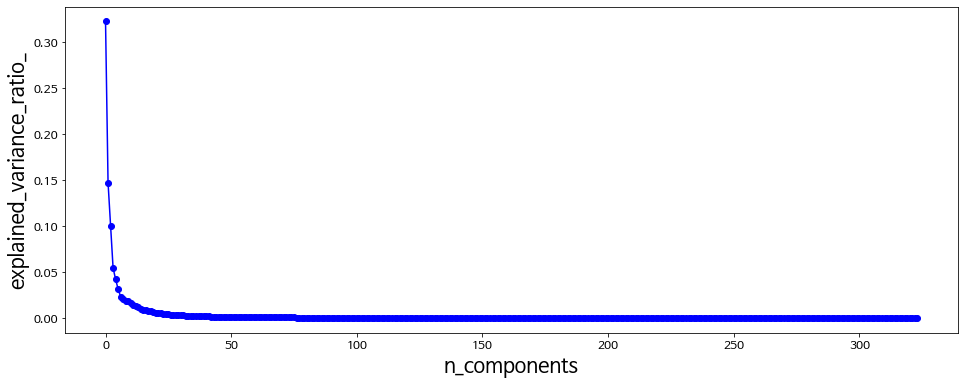

In [ ]:
# 방법1 이용함
# Scree Plot 그리기
# x축 : n_components 수
# y축 : 설명변수
plt.figure(figsize=(16, 6))
plt.plot(pca.explained_variance_ratio_, marker='o', c='blue')
plt.xlabel("n_components", fontsize=20)
plt.ylabel("explained_variance_ratio_", fontsize=20)


# 데이터 가져오기
- 결측치제거, 상관관계0.9이상, 분산이 0인 컬럼 제거후 left, right, ceter관련 피처와 레이블 컬럼이 포함된 377개의 컬럼

In [ ]:
# working_dir = './data/'
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/7회차_Graphviz/data/'
fact_init_data = pd.read_csv(working_dir + 'fact_data_lr_result.csv',index_col='dat...date.name.')
fact_init_data

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,X1WOS45101_PV,X1WOS45105_PV,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DCS_Offset_RPM_M16.1WOS45116_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DAMP.POSITION.1.BAY.CTRL.1TIC33421.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ROOF.HEATING.Zone.7.1JIC31107.PV,ROOF.HEATING.Zone.8.1JIC31108.PV,ROOF.HEATING.Zone.9.1JIC31109.PV,ATM.FLOW.SECT.8.N2.H2.1FI33414.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,cluster,Gross.width,Left.edge,Right.edge,UPPER.AB1.Z1.TMP.1TIC41101.PV,UPPER.AB1.Z6.TMP.1TIC41106.PV,LOWER.AB1.Z9.TMP.1TIC41152.PV,UPPER.AB2.Z20.TMP.1TIC41206.PV,LOWER.AB3.Z37.TMP.1TIC41352.PV,UPPER.AB5.Z57.TMP.1TIC41501.PV,LOWER.AB5.Z67.TMP.1TIC41554.PV,LOWER.AB5.Z69.TMP.1TIC41556.PV,UPPER.AB6.Z71.TMP.1TIC41601.PV,LOWER.AB6.Z78.TMP.1TIC41651.PV,LOWER.AB6.Z83.TMP.1TIC41656.PV,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.AB8.Z99.TMP.1TIC41801.PV,UPPER.AB8.Z101TMP.1TIC41803.PV,...,S_AB3_AB4_L_R,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB5_AB6_L_R,S_AB6_AB7_U_L,S_AB6_AB7_U_R,S_AB6_AB7_L_L,S_AB6_AB7_L_R,S_AB7_AB8_U_L,S_AB7_AB8_L_L,S_AB7_AB8_L_R,S_AB8_AB9_U_L,S_AB8_AB9_L_L,S_AB9_AB10_U_L,S_AB9_AB10_L_L,S_AB10_AB11_U_L,S_AB10_AB11_L_L,S_AB11_C1_U_L,S_AB11_C1_L_L,S_C1_C2_U_L,S_C1_C2_U_R,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_AB1_AB11_L,S_AB11_AB7_L,S_AB7_C4_L,S_C4_RET_L,S_RET_F_L,STD_U_L,STD_U_R,STD_GLS_L,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.772682,-1.730000,-1.804912,0.126294,0.076956,0.076956,0.147152,-0.227141,-3.444664,-1.006303,-1.286936,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,0.115309,1.116636,-4.927747,-1.624702,-0.022694,-1.747928,3.027949,2.433864,2.249020,0.097709,0.009717,0.231688,0.094032,0.110293,0.481077,0.048257,0.832006,0.848586,-0.586741,1.466183,1.290385,-0.185386,0.671585,...,0.848992,0.040088,-0.377177,-1.344386,-0.377875,-0.031034,-2.477830,2.361627,1.128218,2.315215,-0.274508,1.012915,0.742959,-0.398517,-1.310149,0.143574,-1.277785,0.146778,1.772574,-0.038786,1.281424,-0.195736,0.706941,1.477203,0.410847,0.491620,0.942180,2.776941,1.726404,-1.192642,2.599429,-0.365598,-1.963403,0.523950,1.951349,3.012706,0.025,0.063,0.108,0.041
2016-01-01 08,-1.772682,-1.730000,-1.804912,0.126294,0.076956,0.076956,0.147152,-0.227141,-3.444664,-1.006303,-1.286936,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,0.115309,1.116636,-4.927747,-1.624702,-0.022694,-1.747928,3.053693,2.392478,2.325504,0.048449,-0.037427,0.201890,0.042306,0.059390,0.367319,-0.075227,0.738876,0.716378,-0.703541,1.310156,1.189370,-0.183941,0.671585,...,0.834203,0.030658,-0.404578,-1.294084,-0.479823,-0.056337,-2.508000,2.415231,0.913786,2.025935,-0.797190,1.043599,0.830726,-0.367705,-1.300259,0.235959,-1.201661,0.161917,1.871182,-0.082620,1.283889,-0.500742,0.822657,1.495204,0.397591,0.587871,0.938186,2.888919,1.682081,-1.109125,2.588703,-0.348979,-1.978936,0.566521,2.010125,3.022998,0.000,0.022,0.133,0.000
2016-01-01 09,-1.772682,-1.730000,-1.804912,0.126294,0.076956,0.076956,0.147152,-0.227141,-3.444664,-1.006303,-1.286936,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,0.115309,1.116636,-4.927747,-1.624702,-0.022694,-1.747928,3.079437,2.433864,2.325504,0.020966,-0.068528,0.185160,0.015010,0.013961,0.228325,-0.132076,0.628421,0.529988,-0.891235,1.144856,1.041403,-0.203290,0.668109,...,0.812830,0.146174,-0.332660,-1.216127,-0.503408,-0.149875,-2.538873,2.409384,0.643136,1.808018,-1.089624,1.008563,0.770077,-0.393200,-1.263739,0.277785,-1.165167,0.153177,1.826206,-0.080172,1.272749,-0.164556,0.962210,1.552127,0.460702,0.397216,0.843443,2.868644,1.632955,-0.986580,2.550175,-0.456071,-1.878611,0.545936,2.002820,2.936967,0.016,0.063,0.000,0.000
2016-01-01 10,-1.772682,-1.73

# 피처 저장 및 MinMaxScaler
- 레이블(4개)을 제외한 373개 피처를 변수에 저장

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_bf_scale = fact_init_data.iloc[:,:-4]
scaler = MinMaxScaler()

# X_data = scaler.fit_transform(X_bf_scale)
X_data = pd.DataFrame(data=scaler.fit_transform(X_bf_scale), columns=X_bf_scale.columns, index=X_bf_scale.index)
y_data = fact_init_data.iloc[:,-4:]

# 373개 컬럼에 대한 PCA주성분 분석

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_data)
X_data_pca = pca.transform(X_data)

# 주성분의 설명력과 기여율 구하기
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(X_data.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,2.554557e+00,3.163414e-01,0.316341
pca2,1.203831e+00,1.490754e-01,0.465417
pca3,7.758459e-01,9.607624e-02,0.561493
pca4,4.373274e-01,5.415608e-02,0.615649
pca5,3.400667e-01,4.211187e-02,0.657761
...,...,...,...
pca369,4.572814e-22,5.662707e-23,1.000000
pca370,4.354103e-22,5.391867e-23,1.000000
pca371,2.494828e-22,3.089450e-23,1.000000
pca372,1.487501e-22,1.842034e-23,1.000000


## 누적기여율 0.9이상의 컬럼개수 - 24개

In [ ]:
print(len(result[result['누적기여율'] < 0.9]))

24


## Elbow(그래프가 급격히 꺾이는 지점) 확인
- n_components = 7, 주성분 7개로 전체 데이터를 설명할 수 있을 것으로 보임

Text(0, 0.5, 'explained_variance_ratio_')

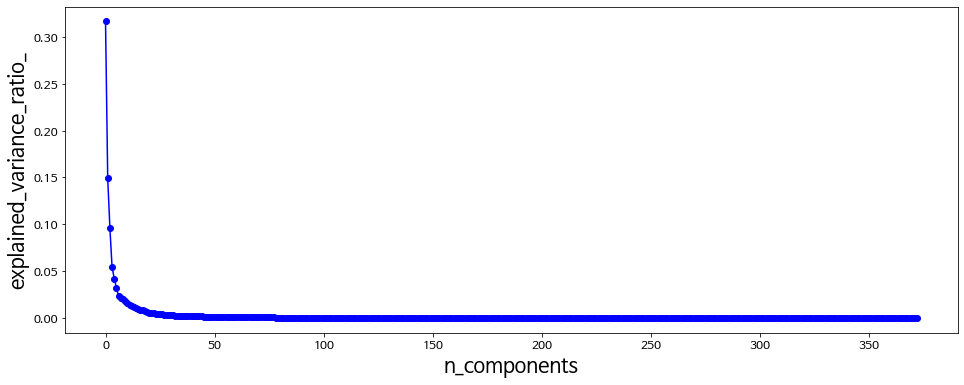

In [ ]:
# 방법1 이용함
# Scree Plot 그리기
# x축 : n_components 수
# y축 : 설명변수
plt.figure(figsize=(16, 6))
plt.plot(pca.explained_variance_ratio_, marker='o', c='blue')
plt.xlabel("n_components", fontsize=20)
plt.ylabel("explained_variance_ratio_", fontsize=20)


# PCA : n_component2개 설정

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_data)
df_pca_2 = pca.transform(X_data)
print(df_pca_2.shape)
new_df_pca_2 =  pd.DataFrame(data=df_pca_2, columns=['PC1','PC2'], index=X_data.index)
new_df_pca_2

(8145, 2)


,PC1,PC2
dat...date.name.,,
2016-01-01 07,3.577244,1.464186
2016-01-01 08,3.561934,1.448741
2016-01-01 09,3.588629,1.464363
2016-01-01 10,3.593467,1.474499
2016-01-01 11,3.653216,1.488370
...,...,...
2016-12-31 19,-0.555484,2.408034
2016-12-31 20,-0.534497,2.440881
2016-12-31 21,-0.500515,2.415586


## PC1과 PC2와의 관계

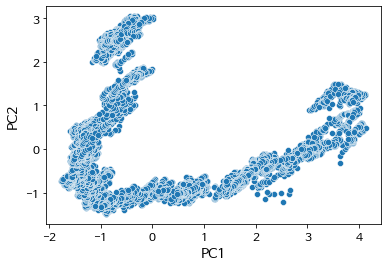

In [ ]:
sns.scatterplot(x=new_df_pca_2.iloc[:,0], y=new_df_pca_2.iloc[:,1])

# 함수

## 양품과 불량품의 비율 그래프를 생성하는 함수

In [ ]:
def show_labels_cnt(y_df):
    rows = 2
    cols = 2
    # constrained_layout : 플롯간의 간격을 자동으로 조절
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(10,8))
    for i in range(len(y_df.columns)):
        # 양품의 개수
        good_RD = y_df.iloc[:,i].value_counts()[0]
        # 불량품의 개수
        bad_RD = y_df.iloc[:,i].value_counts()[1]
        # 카운트 그래프
        a = sns.countplot(x=y_df.columns[i], data=y_df, ax=ax[i//2, i%2])
        cnt = 0
        for p in a.patches:
            height = p.get_height() # 그래프의 높이(개수를 그래프위에 표시하기 위해 필요)
            # 개수를 그래프에 표시
            a.text(p.get_x()+p.get_width()/2., height + 0.1, y_df.iloc[:,i].value_counts()[cnt],ha="center")
            cnt += 1
    plt.show()

## 분류에서의 평가지표를 출력해주는 함수

In [ ]:
## 분류에서의 평가지표를 출력해주는 함수
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('정확도:', accuracy)
    print('정밀도:', precision)
    print('재현율:', recall)
    print('F1:', f1)
    print('AUC:', roc_auc)

##   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프를 보여주는 함수

In [ ]:
def show_feature_label(ft_top24, y_df):
    y_df = y_df.set_index(X_data.index)
    rows = 1
    cols = 5
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(28,5))
    cnt=0
    i = ft_top24.index[0]
    for i in ft_top24.index[:5]:
        concatenated = pd.concat([X_data[i], y_df['L.RD']], axis=1)
        concatenated
        sns.scatterplot(data=concatenated, x=i, y= 'L.RD',ax=ax[cnt])
        cnt+=1
    plt.xlabel(i)
    plt.ylabel('target')
    plt.show()

# 모듈 임포트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

# 임계치 : 상위 5%

## 레이블 라벨링

In [ ]:
quartile_5p = y_data.quantile(q=0.95)

print('<각 컬럼의 상위 5% 임계점>\n',quartile_5p)
y_data_labels_5p = pd.DataFrame(np.where(y_data > quartile_5p, 1, 0), columns = y_data.columns)
y_data_labels_5p.head()

<각 컬럼의 상위 5% 임계점>
 L.RD     0.063
L.Vac    0.082
R.RD     0.099
R.Vac    0.037
Name: 0.95, dtype: float64


,L.RD,L.Vac,R.RD,R.Vac
0,0,0,1,1
1,0,0,1,0
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0


### 임계치가 상위 5% 설정의 경우, 카운트 그래프

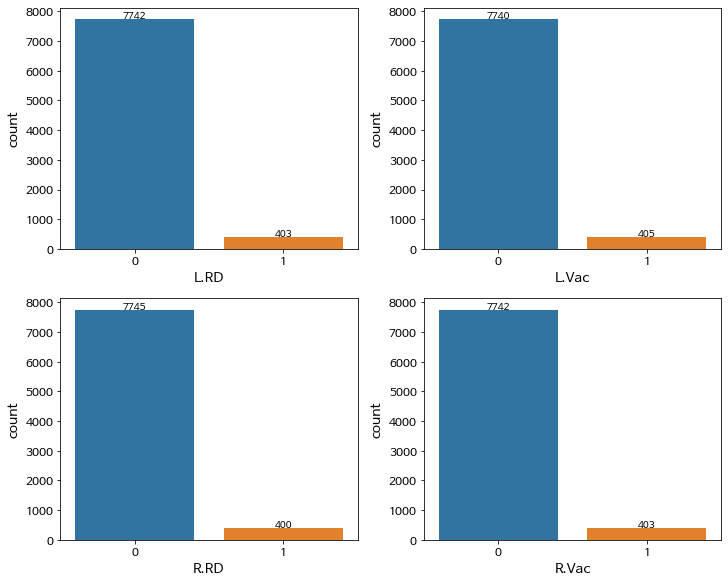

In [ ]:
show_labels_cnt(y_data_labels_5p)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
all_data_5p_LRD = pd.concat([X_data, y_data_labels_5p.iloc[:,0]], axis=1)

X_train_5p, X_test_5p, y_train_5p, y_test_5p = train_test_split(X_data, y_data_labels_5p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_5p.shape)
print(y_test_5p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_5p.value_counts()/y_train_5p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_5p.value_counts()/y_test_5p.count())

(6516,)
(1629,)
0    0.95043
1    0.04957
Name: L.RD, dtype: float64
0    0.95089
1    0.04911
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
print(X_train_5p.shape)
print(y_train_5p.shape)

(6516, 373)
(6516,)


In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9625537139349294
정밀도: 0.7111111111111111
재현율: 0.4
F1: 0.512
AUC: 0.9055196901226599


In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='bootstrapTrueMaxSamplesNone.dot',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','bootstrapTrueMaxSamplesNone.dot', '-o', 'bootstrapTrueMaxSamplesNone.png', '-Gdpi=600'])

0

In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=False)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9607120933087784
정밀도: 0.6538461538461539
재현율: 0.425
F1: 0.5151515151515152
AUC: 0.9233376371852806


In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='bootstrapFalseMaxSamplesNone.dot',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','bootstrapFalseMaxSamplesNone.dot', '-o', 'bootstrapFalseMaxSamplesNone.png', '-Gdpi=600'])

0

In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=0.5)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9607120933087784
정밀도: 0.7222222222222222
재현율: 0.325
F1: 0.44827586206896547
AUC: 0.9092640413169787


In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='bootstrapTrueMaxSamples05.dot',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','bootstrapTrueMaxSamples05.dot', '-o', 'bootstrapTrueMaxSamples05.png', '-Gdpi=600'])

0

In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9625537139349294
정밀도: 0.7111111111111111
재현율: 0.4
F1: 0.512
AUC: 0.9055196901226599


### 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.023744
D_AB7_L_UL                             0.010296
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.009584
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.009150
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.008381
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.007573
TMP.GLASS..ZONE.AB1.E1.1TI40201.PV     0.007325
D_AB8_U_LR                             0.007153
N2.TO.EA1313B.1FI33527A_PV             0.007116
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.007112
ROOF.HEATING.Zone80.1JIC31180.PV       0.007087
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.007043
N2.TO.EA1315B.1FI33528A_PV             0.006878
DB.HEAT.TOP.7.1.TMP.1TI40307.PV        0.006733
S_AB1_AB11_L                           0.006713
D_AB8_L_UL                             0.006663
D_AB3_R_UL                             0.006399
ROOF.HEATING.Zone11.1JIC31111.PV       0.006155
D_AB4_L_LR                             0.005986
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.005982
D_AB6_U_LR                             0

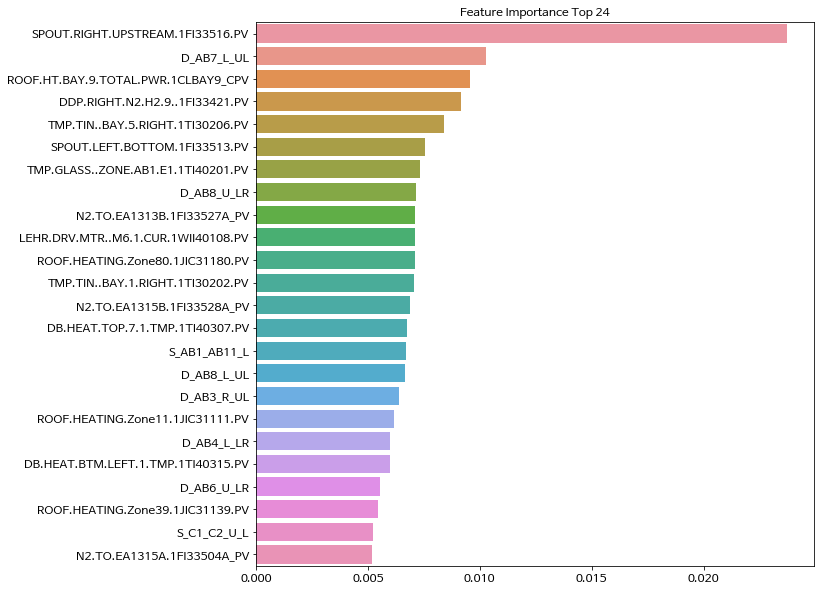

In [ ]:
ft_importance_values_5p = rf_clf_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(모델변수,
                feature_names=X_train_5p.columns,
                out_file='1_randomForest_LRD_5p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_5p_MinMax.dot', '-o', '1_randomForest_LRD_5p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

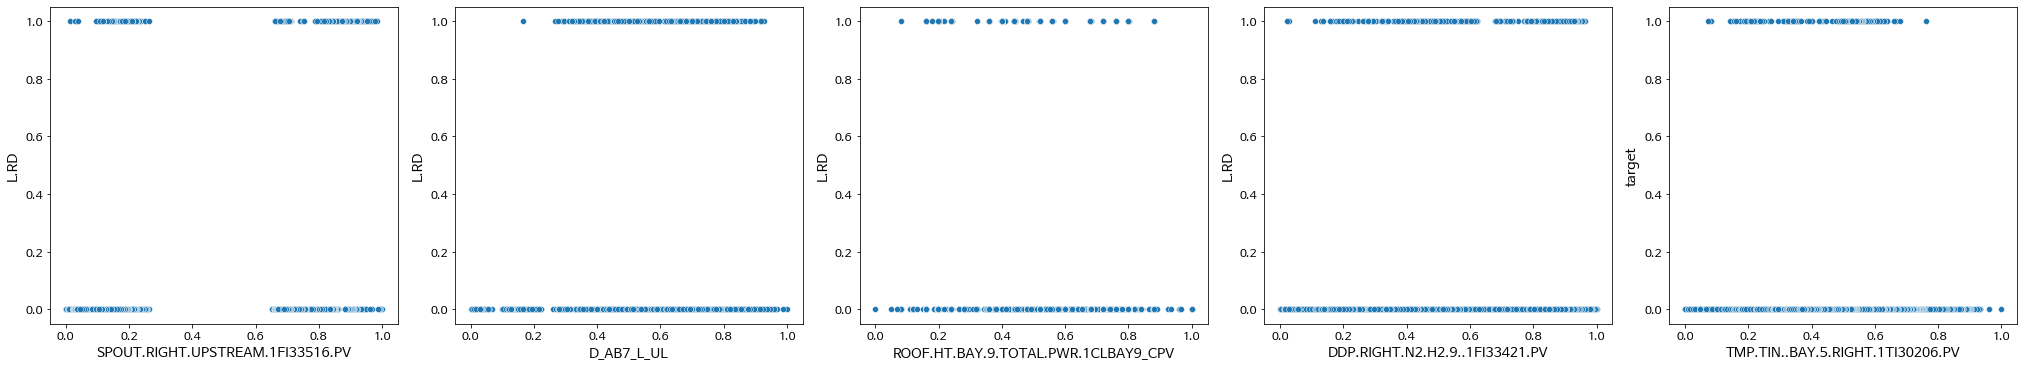

In [ ]:
show_feature_label(ft_top24, y_data_labels_5p)

## 하이퍼파라미터 튜닝

In [ ]:
params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 17, 19, 20], 
          'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50, 100, 130]}

# cv를 5로 설정
# 재현율을 높이도록 하이퍼파라미터 튜닝
gridcv_5 = GridSearchCV(rf_clf_5p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
gridcv_5.fit(X_train_5p, y_train_5p)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
rf_estimator_5p = gridcv_5.best_estimator_
print(rf_estimator_5p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [ ]:
rf_estimator_5p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_5p.fit(X_train_5p, y_train_5p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_predict_5p = rf_estimator_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_estimator_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.958256599140577
정밀도: 0.6875
재현율: 0.275
F1: 0.3928571428571429
AUC: 0.915869109102647


### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.034885
D_AB7_L_UL                             0.028903
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.019026
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.015889
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.014439
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.012364
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.011994
D_AB3_R_UL                             0.010460
DB.BTM.DN.STM.TC.LC.1TI40405_PV        0.010439
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.009596
S_C1_C2_U_L                            0.009542
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.008946
S_AB11_C1_U_L                          0.008784
ATM.N2.H2.5..함유율.1CLFI33402_CPV        0.008659
ROOF.HEATING.Zone41.1JIC31141.PV       0.008601
D_C1_R_UL                              0.008593
D_AB8_L_LR                             0.008533
N2.TO.EA1315B.1FI33528A_PV             0.008232
D_AB4_L_LR                             0.007627
ROOF.HEATING.Zone80.1JIC31180.PV       0.007431
S_AB1_AB11_L                           0

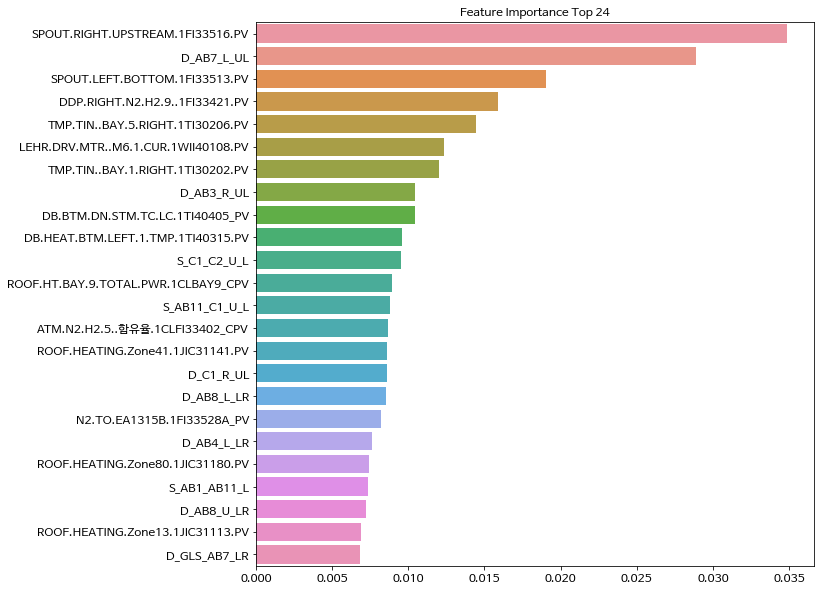

In [ ]:
ft_importance_values_5p = rf_estimator_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

## 피처중요도가 높은 24개의 피처 추출

In [ ]:
X_train_5p_24 = pd.DataFrame(data=X_train_5p,columns=ft_top24.index, index=X_train_5p.index)
X_test_5p_24 = pd.DataFrame(data=X_test_5p,columns=ft_top24.index, index=X_train_5p.index)

In [ ]:
from sklearn.feature_selection import RFE
rfe_selector = RFE(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False),  n_features_to_select= 5)

rfe_fit = rfe_selector.fit(X_train_5p_24, y_train_5p)

In [ ]:
rfe_selector.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
feature_names = X_train_5p_24.columns
X_train_5p_5 = X_train_5p_24[feature_names[rfe_selector.support_]]
X_test_5p_5 = X_test_5p_24[feature_names[rfe_selector.support_]]

In [ ]:
from sklearn.tree import DicisionTreeClassifier
dt_clf = DicisionTreeClassifier(random_state=42, max_leaf_nodes=20)
dt_clf

ImportError: ignored

### 트리구조 저장 및 출력

In [ ]:
estimator_5p  = rf_estimator_5p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_5p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_5p_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_5p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

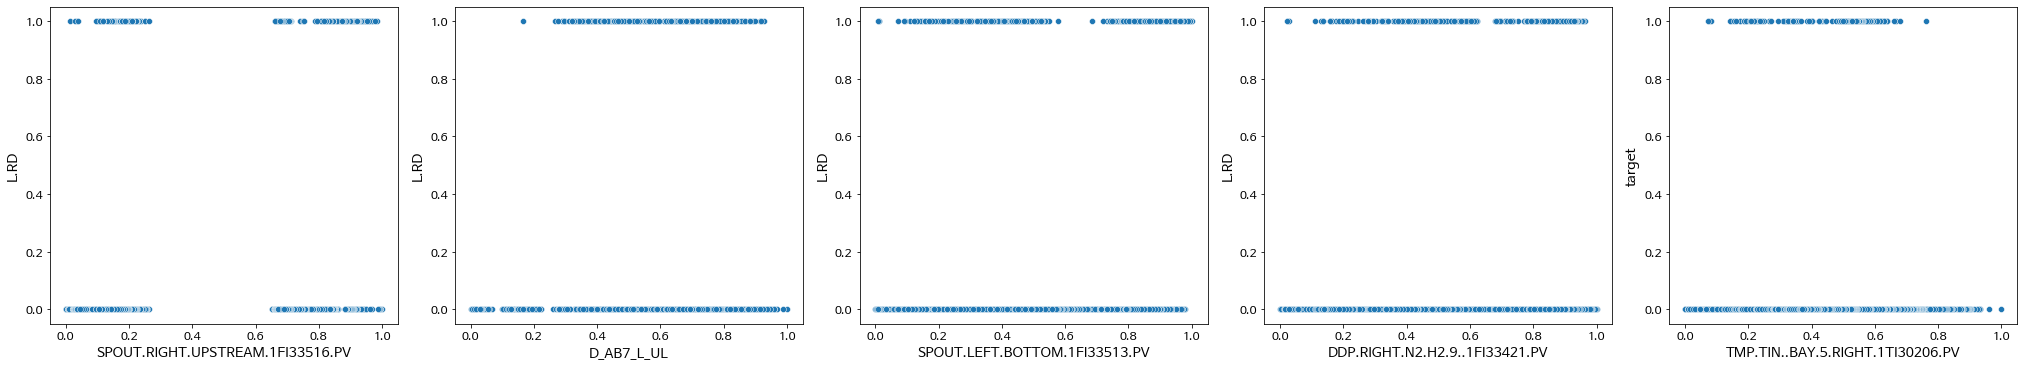

In [ ]:
show_feature_label(ft_top24, y_data_labels_5p)

# 임계치 : 상위 10%
## 레이블 라벨링

In [ ]:
quartile_10p = y_data.quantile(q=0.9)

print('<각 컬럼의 상위 10% 임계점>\n',quartile_10p)
y_data_labels_10p = pd.DataFrame(np.where(y_data > quartile_10p, 1, 0), columns = y_data.columns)
y_data_labels_10p.head()

<각 컬럼의 상위 10% 임계점>
 L.RD     0.040
L.Vac    0.050
R.RD     0.066
R.Vac    0.026
Name: 0.9, dtype: float64


,L.RD,L.Vac,R.RD,R.Vac
0,0,1,1,1
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,0


In [ ]:
origin_y_data = y_data.copy()
y_data_labels_10p = y_data.copy()

quartile_10p = origin_y_data.quantile(q=0.9)
print('<각 컬럼의 상위 10% 임계점>\n',quartile_10p)
for i in range(len(origin_y_data.columns)) : 
    column_name = origin_y_data.columns[i]

    # 양품 데이터 설정
    y_data_labels_10p[column_name] = 0
    condition = (origin_y_data[column_name] > quartile_10p[i])
    # 불량품 레이블 데이터 설정
    y_data_labels_10p[column_name][condition] = 1

<각 컬럼의 상위 10% 임계점>
 L.RD     0.040
L.Vac    0.050
R.RD     0.066
R.Vac    0.026
Name: 0.9, dtype: float64


### 임계치가 상위 10% 설정의 경우, 카운트 그래프

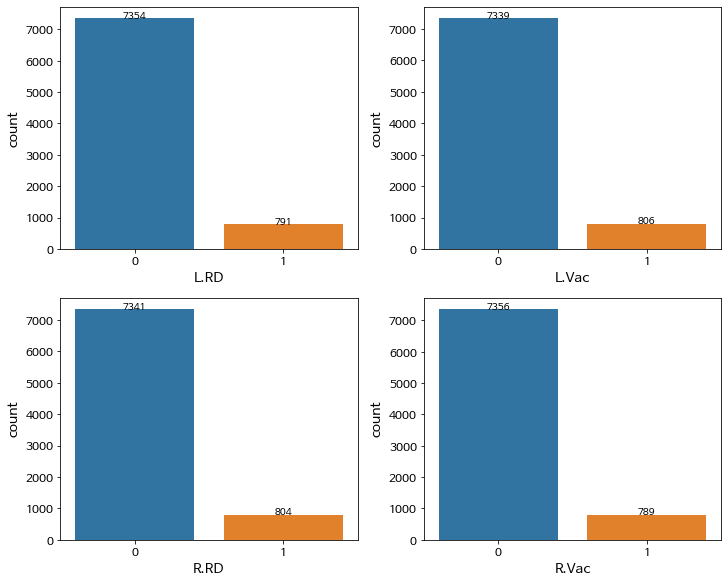

In [ ]:
show_labels_cnt(y_data_labels_10p)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
X_train_10p, X_test_10p, y_train_10p, y_test_10p = train_test_split(X_data, y_data_labels_10p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_10p.shape)
print(y_test_10p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_10p.value_counts() / y_train_10p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_10p.value_counts() / y_test_10p.count())

(6516,)
(1629,)
0    0.902701
1    0.097299
Name: L.RD, dtype: float64
0    0.903622
1    0.096378
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_10p = RandomForestClassifier(random_state=42)
rf_clf_10p.fit(X_train_10p, y_train_10p)
rf_predict_10p = rf_clf_10p.predict(X_test_10p)
rf_predict_proba_10p = rf_clf_10p.predict_proba(X_test_10p)[:,1]
get_clf_eval(y_test_10p, rf_predict_10p, rf_predict_proba_10p)

정확도: 0.9238796807857581
정밀도: 0.7037037037037037
재현율: 0.3630573248407643
F1: 0.4789915966386554
AUC: 0.8598812655774023


### 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.017466
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.009039
D_AB7_L_UL                             0.008997
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.008361
S_AB10_AB11_L_L                        0.007309
N2.TO.EA1315B.1FI33528A_PV             0.007083
S_AB11_C1_U_L                          0.006919
DB.HEAT.TOP.6.2.TMP.1TI40313.PV        0.006638
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.006359
N2.TO.EA1313B.1FI33527A_PV             0.006314
X.1.LEHR.O2.ANALYZER.1AI44111.PV       0.006153
D_AB3_R_UL                             0.006127
ROOF.HEATING.Zone11.1JIC31111.PV       0.005755
LOWER.C1..Z168.TMP.1TIC42257.PV        0.005681
D_AB6_U_LR                             0.005493
DB.BTM.DN.STM.TC.RC.1TI40407_PV        0.005485
ROOF.HEATING.Zone27.1JIC31127.PV       0.005445
cluster                                0.005368
D_C1_L_UL                              0.005256
D_AB7_L_LR                             0.005242
D_C1_R_UL                              0

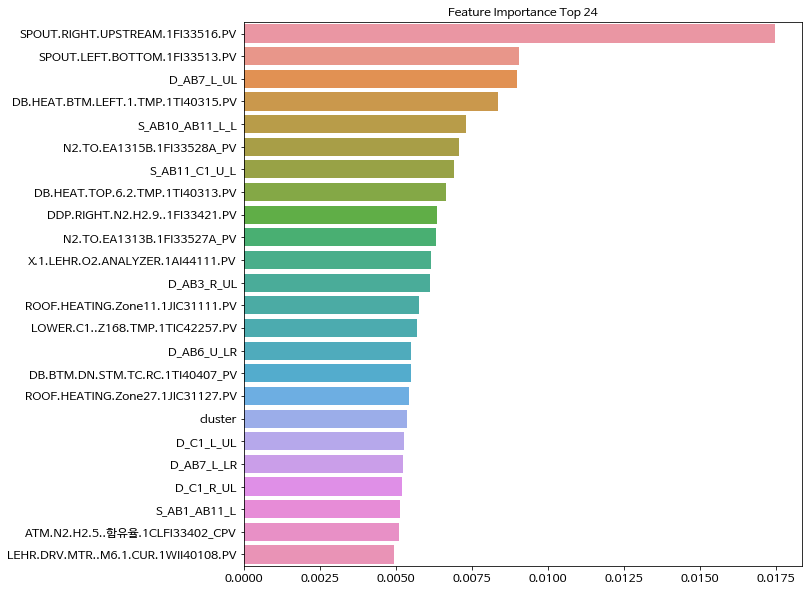

In [ ]:
ft_importance_values_10p = rf_clf_10p.feature_importances_
ft_series_10p = pd.Series(ft_importance_values_10p, index = X_train_10p.columns)
ft_top24 = ft_series_10p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_10p  = rf_clf_10p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_10p,
                  feature_names=X_data.columns,
                out_file='1_randomForest_LRD_10p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_10p_MinMax.dot', '-o', working_dir + '1_randomForest_LRD_10p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

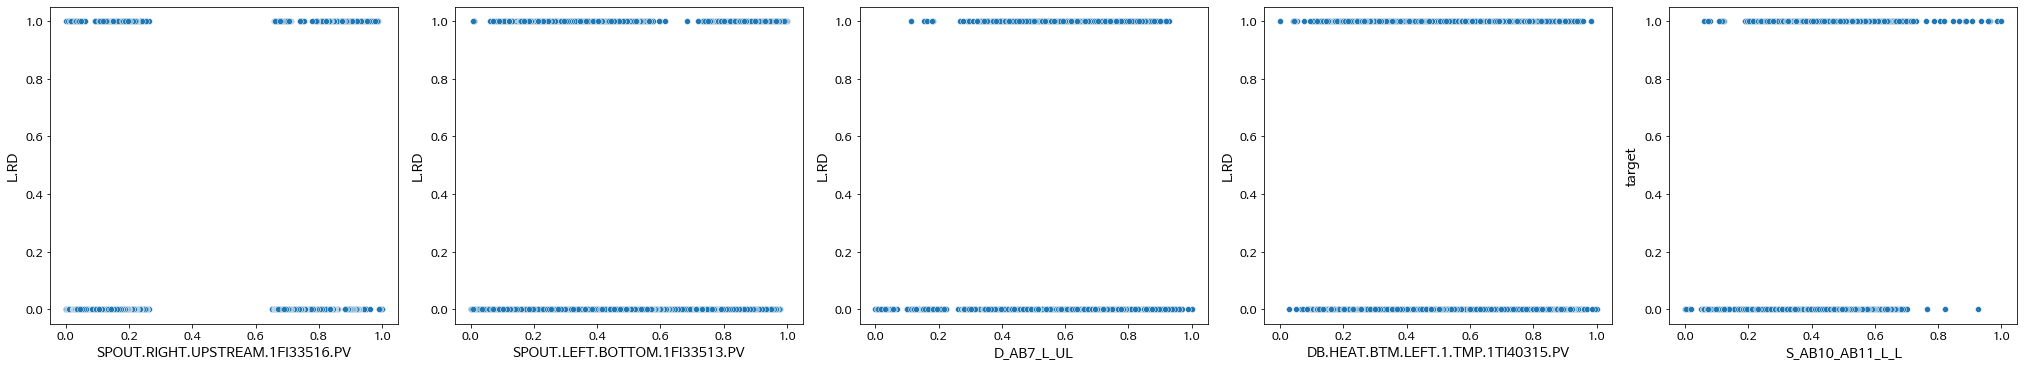

In [ ]:
show_feature_label(ft_top24, y_data_labels_10p)

## 하이퍼파라미터 튜닝

In [ ]:
# #파라미터 생성 - 시간 관계상 파라미터의 개수를 2개씩으로 설정한 것이고
# #실제 모델을 가지고 학습할 때는 더 다양한 값을 설정해야 합니다.
# params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 18, 20], 
#           'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50,  100]}

# # cv를 5로 설정
# # 재현율을 높이도록 하이퍼파라미터 튜닝
# gridcv_10p = GridSearchCV(rf_clf_10p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
# gridcv_10p.fit(X_train_10p, y_train_10p)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
# rf_estimator_10p = gridcv_10p.best_estimator_
# print(rf_estimator_10p)
# rf_predict_10p = rf_estimator_10p.predict(X_test_10p)
# rf_predict_proba_10p = rf_estimator_10p.predict_proba(X_test_10p)[:, 1]
# get_clf_eval(y_test_10p, rf_predict_10p, rf_predict_proba_10p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
정확도: 0.9220380601596071
정밀도: 0.7419354838709677
재현율: 0.2929936305732484
F1: 0.4200913242009133
AUC: 0.8524430559401828


In [ ]:
rf_estimator_10p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_10p.fit(X_train_10p, y_train_10p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.033748
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.016409
DB.HEAT.TOP.6.2.TMP.1TI40313.PV        0.015341
cluster                                0.010601
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.010298
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.010142
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.009402
X.1.LEHR.O2.ANALYZER.1AI44111.PV       0.009299
D_C1_L_UL                              0.008755
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.008680
S_AB11_C1_U_L                          0.008481
LOWER.C1..Z168.TMP.1TIC42257.PV        0.008015
D_C1_R_UL                              0.007690
D_AB7_L_UL                             0.007614
D_AB8_R_UL                             0.007363
LOWER.C2..Z182.TMP.1TIC42357.PV        0.007311
D_AB3_R_UL                             0.007213
N2.TO.EA1315B.1FI33528A_PV             0.007120
D_AB8_L_UL                             0.006254
DB.BTM.DN.STM.TC.LE.1TI40404_PV        0.006207
D_AB6_U_LR                             0

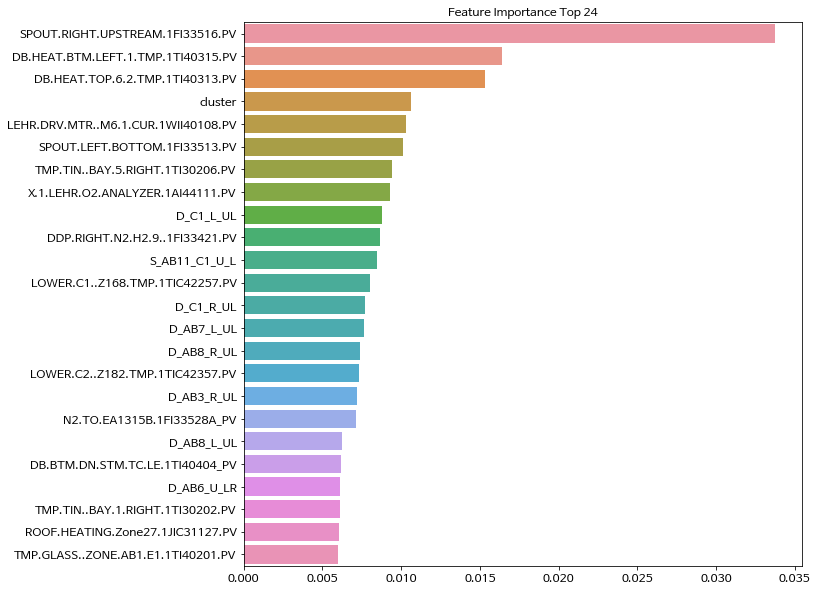

In [ ]:
ft_importance_values_10p = rf_estimator_10p.feature_importances_
ft_series_10p = pd.Series(ft_importance_values_10p, index = X_train_10p.columns)
ft_top24 = ft_series_10p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_10p  = rf_estimator_10p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_10p,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_10p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_10p_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_10p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

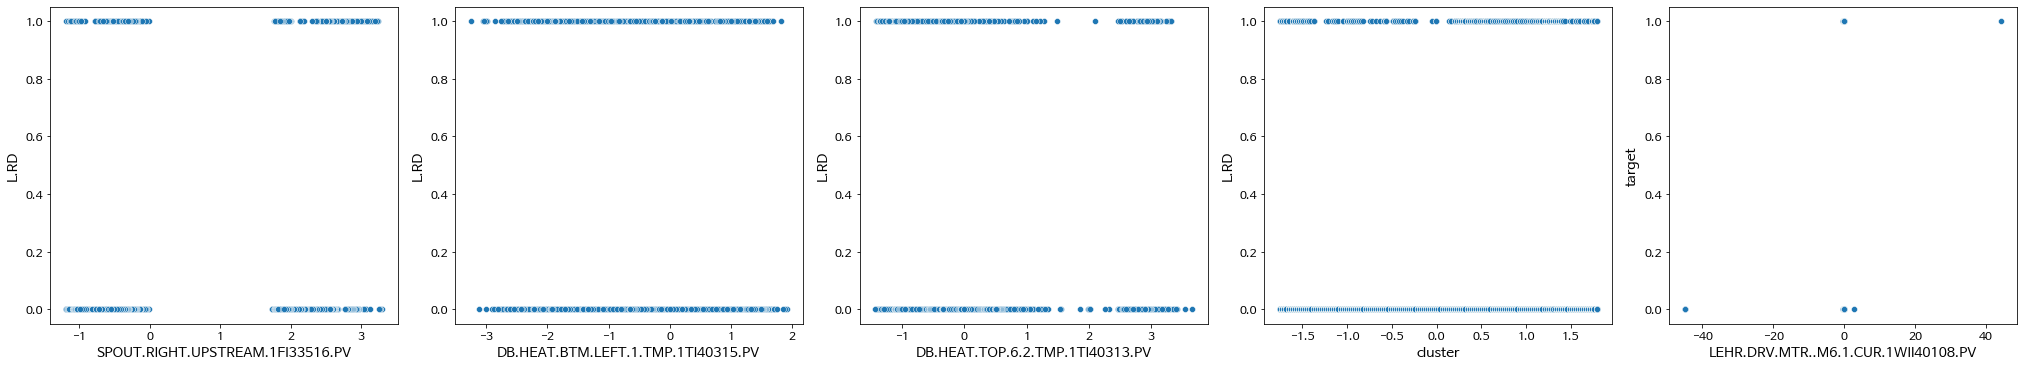

In [ ]:
show_feature_label(ft_top24, y_data_labels_10p)

# 임계치: 0.01 
- 레이블에 대해 불량품(1)과 양품(0)으로 분류
- 0.01이상의 데이터는 불량품, 이외는 양품으로 Labeling을 한다.


In [ ]:
y_data_labels_001 = pd.DataFrame(np.where(y_data > 0.01, 1, 0), columns = y_data.columns)
y_data_labels_001.head()

,L.RD,L.Vac,R.RD,R.Vac
0,1,1,1,1
1,0,1,1,0
2,1,1,0,0
3,0,1,0,0
4,0,0,0,0


### 임계치가 0.01 설정의 경우, 카운트 그래프

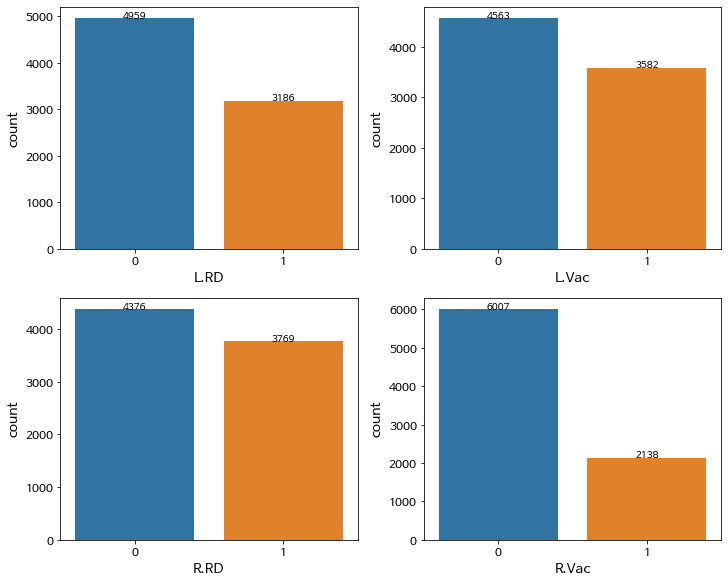

In [ ]:
show_labels_cnt(y_data_labels_001)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
X_train_001, X_test_001, y_train_001, y_test_001 = train_test_split(X_data, y_data_labels_001.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_001.shape)
print(y_test_001.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_001.value_counts()/y_train_001.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_001.value_counts()/y_test_001.count())

(6516,)
(1629,)
0    0.610804
1    0.389196
Name: L.RD, dtype: float64
0    0.600982
1    0.399018
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_001 = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_001.fit(X_train_001, y_train_001)
rf_predict_001 = rf_clf_001.predict(X_test_001)
rf_predict_proba_001 = rf_clf_001.predict_proba(X_test_001)[:,1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

정확도: 0.6930632289748312
정밀도: 0.6420454545454546
재현율: 0.5215384615384615
F1: 0.5755517826825127
AUC: 0.7385173253712579


### 하이퍼파라미터 튜닝 전의 피처 중요도

S_AB11_C1_U_L                            0.008785
cluster                                  0.007251
S_AB11_C1_L_L                            0.006934
ROOF.HT.BAY.11.TOTAL.PWR.1CLBAY11_CPV    0.006346
LOWER.C1..Z168.TMP.1TIC42257.PV          0.006305
TMP.TIN..BAY.5.RIGHT.1TI30206.PV         0.005511
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV       0.005288
LEHR.DRV.MTR..M7.1.SPD.1WSI40110.1       0.005207
TMP.TIN..BAY.1.RIGHT.1TI30202.PV         0.004861
D_C1_L_UL                                0.004859
LOWER.C3..Z193TMP.1TIC42454.PV           0.004791
ROOF.HEATING.Zone49.1JIC31149.PV         0.004591
ROOF.HEATING.Zone36.1JIC31136.PV         0.004581
UPPER.C2..Z175.TMP.1TIC42307.PV          0.004574
DB.BTM.UP.STM.TC.RE.1TI40403_PV          0.004570
S_C1_C2_U_L                              0.004454
UPPER.C1..Z155.TMP.1TIC42201.PV          0.004448
ROOF.HEATING.Zone57.1JIC31157.PV         0.004355
S_C2_C3_U_R                              0.004320
ROOF.HEATING.Zone63.1JIC31163.PV         0.004168


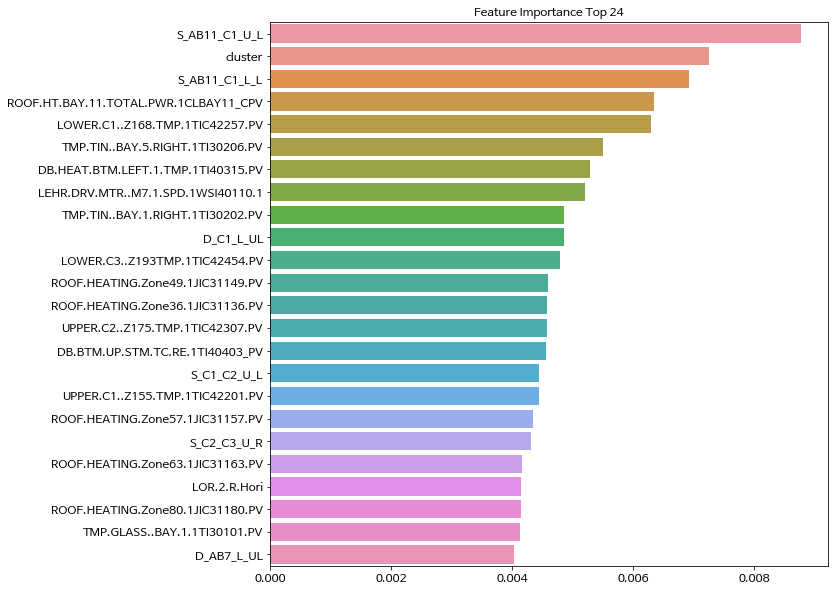

In [ ]:
ft_importance_values_001 = rf_clf_001.feature_importances_
ft_series_001 = pd.Series(ft_importance_values_001, index = X_train_001.columns)
ft_top24 = ft_series_001.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_001  = rf_clf_001.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_001,
                  feature_names=X_data.columns,
                out_file='1_randomForest_LRD_001_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_001_MinMax.dot', '-o', working_dir + '1_randomForest_LRD_001_MinMax.png', '-Gdpi=600'])

0

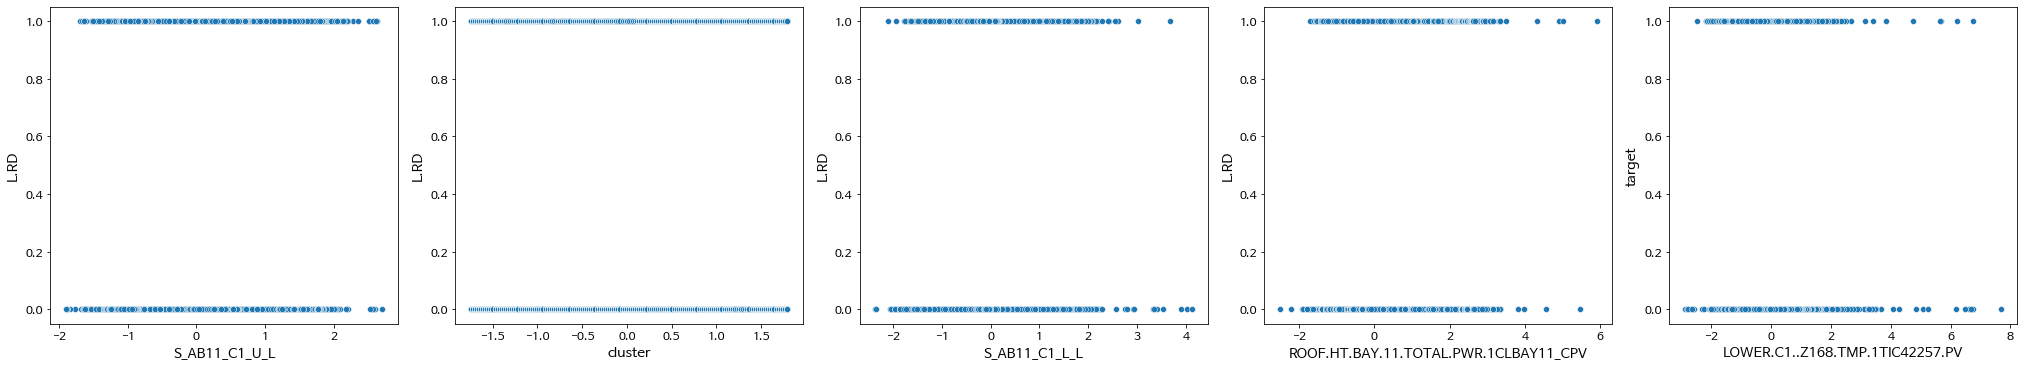

In [ ]:
show_feature_label(ft_top24, y_data_labels_001)

## 하이퍼파라미터 튜닝

In [ ]:
# #파라미터 생성 - 시간 관계상 파라미터의 개수를 2개씩으로 설정한 것이고
# #실제 모델을 가지고 학습할 때는 더 다양한 값을 설정해야 합니다.
# params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 18, 20], 
#           'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50,  100]}

# # cv를 5로 설정
# # 재현율을 높이도록 하이퍼파라미터 튜닝
# gridcv_001 = GridSearchCV(rf_clf_001, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
# gridcv_001.fit(X_train_001, y_train_001)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
# rf_estimator_001 = gridcv_001.best_estimator_
# print(rf_estimator_001)
# rf_predict_001 = rf_estimator_001.predict(X_test_001)
# rf_predict_proba_001 = rf_estimator_001.predict_proba(X_test_001)[:, 1]
# get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
정확도: 0.6924493554327809
정밀도: 0.6435452793834296
재현율: 0.5138461538461538
F1: 0.5714285714285715
AUC: 0.7359267698593541


In [ ]:
# rf_estimator_001 = gridcv_001.best_estimator_
rf_estimator_001 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_001.fit(X_train_001, y_train_001)
rf_predict_001 = rf_estimator_001.predict(X_test_001)
rf_predict_proba_001 = rf_estimator_001.predict_proba(X_test_001)[:, 1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

정확도: 0.6924493554327809
정밀도: 0.6435452793834296
재현율: 0.5138461538461538
F1: 0.5714285714285715
AUC: 0.7359267698593541


### 하이퍼파라미터 튜닝 후의 피처 중요도

LEHR.DRV.MTR..M7.1.SPD.1WSI40110.1     0.017240
S_AB11_C1_L_L                          0.011341
cluster                                0.009837
D_C1_L_UL                              0.009624
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.009026
ATM.FLOW.SECT.10.N2.1FIC33417.PV       0.008697
LOWER.C1..Z168.TMP.1TIC42257.PV        0.007849
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.007298
TMP.TIN..BAY.5.LEFT.1TI30205.PV        0.007154
SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.006775
ROOF.HEATING.Zone36.1JIC31136.PV       0.006743
DB.BTM.DN.STM.TC.LE.1TI40404_PV        0.006741
TMP.GLASS..Z_RET.E1.1TI40241.PV        0.006639
UPPER.C1..Z155.TMP.1TIC42201.PV        0.006618
TMP.GLASS..BAY.6.1TI30106.PV           0.006544
LOWER.C3..Z193TMP.1TIC42454.PV         0.006104
ROOF.HT.BAY.7.TOTAL.PWR.1CLBAY7_CPV    0.006057
DB.BTM.UP.STM.TC.RE.1TI40403_PV        0.006017
ROOF.HEATING.Zone.9.1JIC31109.PV       0.005542
l_r_tin_bay5                           0.005506
S_AB1_AB2_U_L                          0

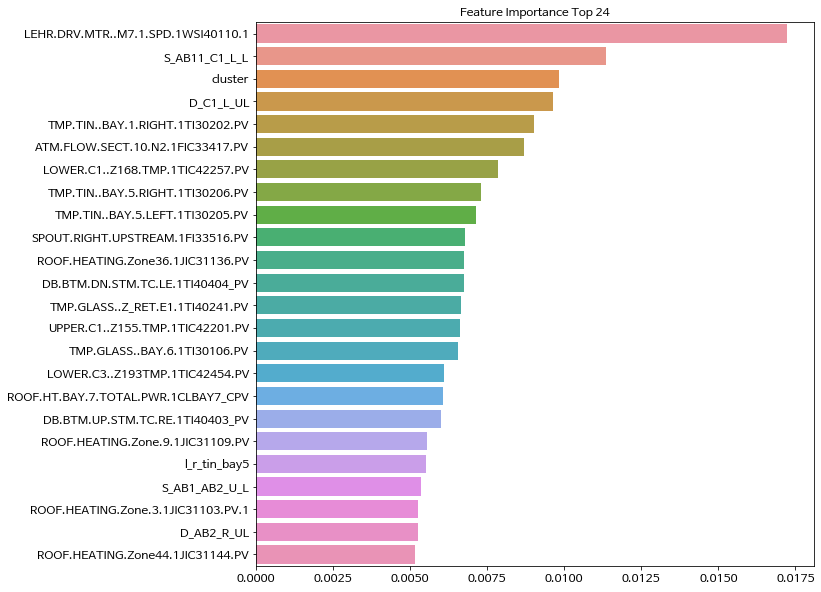

In [ ]:
ft_importance_values_001 = rf_estimator_001.feature_importances_
ft_series_001 = pd.Series(ft_importance_values_001, index = X_train_001.columns)
ft_top24 = ft_series_001.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_001  = rf_estimator_001.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_001,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_001_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_001_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_001_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

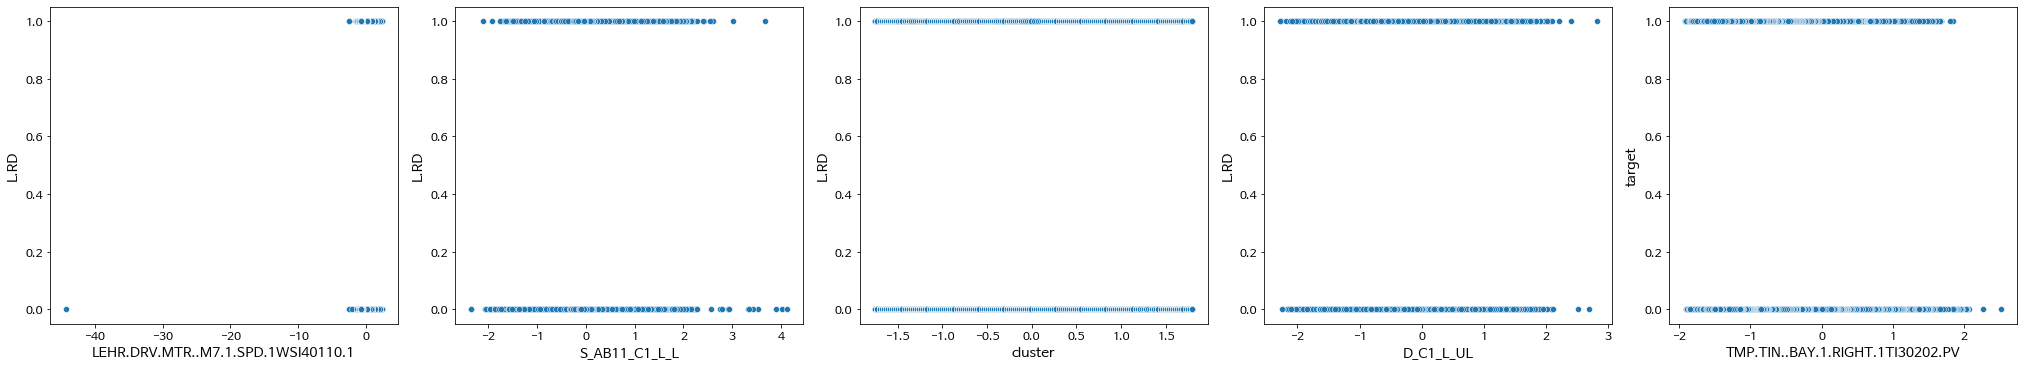

In [ ]:
show_feature_label(ft_top24, y_data_labels_001)